In [ ]:
import os
import pandas as pd
import numpy as np
import time
from datetime import date
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split



os.chdir("d:/Vdata/")
VIXdata = pd.read_csv("1_startingDatapull.csv")
VIXdata["Date"] = pd.to_datetime(VIXdata["datadate"], format="%Y%m%d")


VIXdata.head()
import polars as pl

VIXdata = pl.from_pandas(VIXdata)
VIXdata = VIXdata.select(["Date"] + [col for col in VIXdata.columns if col != "Date"])

VIXdata.head(5)

In [ ]:
# the chain needs to be separated. Polars evaluates all expressions in parallel, so intermediate columns like mu or mat20 aren’t yet available to reference inside the same call.
VIXdata = VIXdata.with_columns(
    y = (-1 * ((pl.col("SPVXSP").shift(-1) / pl.col("SPVXSP")) - 1)), # y is the XIV ret for the next day

    SPYret  = ((pl.col("SPY") / pl.col("SPY").shift(1)) - 1),
    VIXret  = ((pl.col("VIX") / pl.col("VIX").shift(1)) - 1),
    XIVret  = (-1 * ((pl.col("SPVXSP") / pl.col("SPVXSP").shift(1)) - 1)),
    mat20 = (pl.col("w1") * pl.col("VX1")**2 + pl.col("w2") * pl.col("VX2")**2).sqrt()
).with_columns(
    mu = (pl.col("mat20") / pl.col("VIX") - 1),
    prem = (pl.col("mat20") / pl.col("VIX3M")), 
).with_columns(
    lagmu = pl.col("mu").shift(1),
    dmu = pl.col("mu") - pl.col("mu").shift(1),
    vratio = (pl.col("VIX3M") / pl.col("VIX") - 1),
    lagvratio = (pl.col("VIX3M") / pl.col("VIX") - 1).shift(1),
    dvratio = (pl.col("VIX3M") / pl.col("VIX") - 1) - (pl.col("VIX3M") / pl.col("VIX") - 1).shift(1)
)

print(VIXdata.head())

In [ ]:
import polars as pl

algos = []
count = 1
final = VIXdata

# mu <= -0.19
check = (
    final.filter(pl.col("mu") <= -0.19)
    .with_columns(
        state = pl.when((pl.col("SPYret") < 0.042) & (pl.col("vratio") > -0.11)).then(1)
                .when((pl.col("SPYret") < 0.042) & (pl.col("VIXret") > 0.38) & (pl.col("VIX") > 29) & (pl.col("vratio") <= -0.11)).then(2)
                .when((pl.col("SPYret") < 0.042) & (pl.col("VIXret") < 0.38) & (pl.col("VIX") > 29) & (pl.col("vratio") <= -0.11) & (pl.col("dvratio") > 0.027)).then(3)
                .when((pl.col("SPYret") < 0.042) & (pl.col("VIXret") < 0.38) & (pl.col("VIXret") > 0.18) & (pl.col("VIX") > 29) & (pl.col("vratio") <= -0.11) & (pl.col("dvratio") < 0.027)).then(4)
                .otherwise(0)
    )
    .with_columns(
        pos = pl.when(pl.col("state") == 0).then(-1)
              .when((pl.col("state") >= 1) & (pl.col("state") < 4)).then(0.3)
              .when(pl.col("state") == 4).then(0.05)
              .otherwise(None),
        Algo = pl.lit(count)
    )
)
algos.append(check)
count += 1

# mu > -0.19 & mu <= -0.08
check = (
    final.filter((pl.col("mu") > -0.19) & (pl.col("mu") <= -0.08))
    .with_columns(
        state = pl.when((pl.col("lagvratio") < 0.075) & (pl.col("mu") >= -0.094)).then(1)
                .when((pl.col("lagvratio") <= -0.12) & (pl.col("vratio") >= -0.13) & (pl.col("mu") <= -0.094)).then(2)
                .when((pl.col("lagvratio") <= -0.048) & (pl.col("lagvratio") >= -0.073) & (pl.col("vratio") > -0.13) & (pl.col("mu") <= -0.094)).then(3)
                .when((pl.col("lagvratio") >= -0.048) & (pl.col("lagvratio") < 0.075) & (pl.col("vratio") > -0.034) & (pl.col("mu") <= -0.11)).then(4)
                .when(pl.col("lagvratio") >= 0.075).then(5)
                .otherwise(0)
    )
    .with_columns(
        pos = pl.when(pl.col("state").is_in([0, 5])).then(-0.7)
              .otherwise(0.2),
        Algo = pl.lit(count)
    )
)
algos.append(check)
count += 1

# mu > -0.08 & mu <= 0.0
check = (
    final.filter((pl.col("mu") > -0.08) & (pl.col("mu") <= 0.0))
    .with_columns(
        state = pl.when(pl.col("SPYret") <= -0.035).then(1)
                .when((pl.col("SPYret") >= -0.035) & (pl.col("VIXret") > 0.26)).then(2)
                .when((pl.col("SPYret") >= -0.035) & (pl.col("VIXret") < 0.24) & (pl.col("lagmu") <= -0.12)).then(3)
                .when((pl.col("SPYret") >= -0.035) & (pl.col("VIXret") < 0.24) & (pl.col("lagmu") >= -0.12) & (pl.col("dmu") > 0.031) & (pl.col("dmu") <= 0.043)).then(4)
                .when((pl.col("SPYret") >= -0.035) & (pl.col("VIXret") < 0.26) & (pl.col("VIXret") >= 0.24)).then(5)
                .when((pl.col("SPYret") >= 0.0053) & (pl.col("VIXret") < 0.24) & (pl.col("lagmu") >= -0.12) & (pl.col("dmu") >= 0.043) & (pl.col("dmu") <= 0.061)).then(6)
                .otherwise(0)
    )
    .with_columns(
        pos = pl.when(pl.col("state") == 0).then(0.05)
              .when(pl.col("state").is_in([1, 2, 3, 4])).then(0.6)
              .when(pl.col("state") >= 5).then(-0.3),
        Algo = pl.lit(count)
    )
)
algos.append(check)
count += 1

# mu > 0.0 & mu <= 0.07
check = (
    final.filter((pl.col("mu") > 0.0) & (pl.col("mu") <= 0.07))
    .with_columns(
        state = pl.when((pl.col("VIX") > 30) & (pl.col("vratio") > 0.071)).then(1)
                .when((pl.col("VIX") > 30) & (pl.col("vratio") < 0.071)).then(2)
                .when((pl.col("VIX") < 27) & (pl.col("dvratio") >= -0.099) & (pl.col("SPYret") <= -0.0014)).then(3)
                .otherwise(0)
    )
    .with_columns(
        pos = pl.when(pl.col("state") == 0).then(-0.1)
              .when(pl.col("state") == 1).then(0.7)
              .when(pl.col("state") >= 2).then(0.3),
        Algo = pl.lit(count)
    )
)
algos.append(check)
count += 1

# mu > 0.07 & mu <= 0.1
check = (
    final.filter((pl.col("mu") > 0.07) & (pl.col("mu") <= 0.1))
    .with_columns(
        state = pl.when((pl.col("lagvratio") <= 0.16) & (pl.col("dmu") >= 0.091)).then(1)
                .when((pl.col("lagvratio") >= 0.16) & (pl.col("lagmu") < 0.16) & (pl.col("vratio") < 0.15)).then(2)
                .when((pl.col("lagvratio") >= 0.16) & (pl.col("lagmu") > 0.16)).then(3)
                .otherwise(0)
    )
    .with_columns(
        pos = pl.when(pl.col("state") == 0).then(0.5)
              .when(pl.col("state").is_in([1, 2])).then(-0.3)
              .when(pl.col("state") > 2).then(0.7),
        Algo = pl.lit(count)
    )
)
algos.append(check)
count += 1

# mu > 0.1 & mu < 0.15
check = (
    final.filter((pl.col("mu") > 0.1) & (pl.col("mu") < 0.15))
    .with_columns(
        state = pl.when((pl.col("lagvratio") >= 0.14) & (pl.col("lagmu") < 0.081)).then(1)
                .when((pl.col("lagvratio") >= 0.14) & (pl.col("lagmu") > 0.081) & (pl.col("SPYret") >= -0.0016) & (pl.col("SPYret") <= -0.0015)).then(2)
                .when((pl.col("lagvratio") >= 0.14) & (pl.col("lagmu") > 0.081) & (pl.col("SPYret") >= -0.0015)).then(3)
                .otherwise(0)
    )
    .with_columns(
        pos = pl.when(pl.col("state") == 0).then(0.5)
              .when(pl.col("state").is_in([1, 2])).then(-0.4)
              .when(pl.col("state") > 2).then(-0.2),
        Algo = pl.lit(count)
    )
)
algos.append(check)
count += 1

# mu > 0.1
check = (
    final.filter(pl.col("mu") > 0.1)
    .with_columns(
        state = pl.when((pl.col("lagvratio") >= 0.15) & (pl.col("lagmu") < 0.1)).then(1)
                .when((pl.col("lagvratio") >= 0.15) & (pl.col("lagmu") >= 0.1)).then(2)
                .otherwise(0)
    )
    .with_columns(
        pos = pl.when(pl.col("state") == 0).then(0.6)
              .when(pl.col("state") == 1).then(-0.2)
              .when(pl.col("state") == 2).then(0.1),
        Algo = pl.lit(count)
    )
)
algos.append(check)
count += 1

# mu [0,0.05]
check = (
    final.filter((pl.col("mu") >= 0.0) & (pl.col("mu") <= 0.05))
    .with_columns(
        state = pl.when((pl.col("VIX") >= 30) & (pl.col("vratio") > 0.071)).then(1)
                .when((pl.col("VIX") >= 30) & (pl.col("vratio") < 0.071)).then(2)
                .when((pl.col("VIX") <= 27) & (pl.col("VIX") > 18) & (pl.col("lagmu") <= 0.11) & (pl.col("lagvratio") > 0.15)).then(3)
                .when((pl.col("VIX") <= 27) & (pl.col("VIX") > 18) & (pl.col("lagmu") <= 0.11) & (pl.col("lagvratio") < 0.15)).then(4)
                .when((pl.col("VIX") < 30) & (pl.col("VIX") >= 27) & (pl.col("mu") >= 0.036)).then(5)
                .when((pl.col("VIX") < 18) & (pl.col("VIX") >= 17)).then(6)
                .when((pl.col("VIX") <= 27) & (pl.col("VIX") > 18) & (pl.col("lagmu") >= 0.11)).then(7)
                .otherwise(0)
    )
    .with_columns(
        pos = pl.when(pl.col("state") == 0).then(0)
               .when((pl.col("state") >= 1) & (pl.col("state") <= 4)).then(0.3)
               .when(pl.col("state") >= 5).then(-0.3),
        Algo = pl.lit(count)
    )
)
algos.append(check)
count += 1

# mu [0.05,0.1]
check = (
    final.filter((pl.col("mu") >= 0.05) & (pl.col("mu") <= 0.1))
    .with_columns(
        state = pl.when((pl.col("mu") > 0.057) & (pl.col("lagvratio") < 0.17)).then(1)
                .when((pl.col("mu") > 0.057) & (pl.col("lagvratio") >= 0.17) & (pl.col("lagmu") > 0.16)).then(2)
                .when((pl.col("mu") < 0.057) & 
                      (pl.col("VIXret") > -0.094) & 
                      (pl.col("SPYret") > -0.0095) & 
                      (pl.col("SPYret") <= -0.0013) & 
                      (pl.col("VIXret") <= 0.0068)).then(3)
                .when((pl.col("mu") > 0.057) & 
                      (pl.col("lagvratio") >= 0.17) & 
                      (pl.col("lagmu") < 0.16) & 
                      (pl.col("vratio") > 0.15)).then(4)
                .otherwise(0)
    )
    .with_columns(
        pos = pl.when(pl.col("state") == 0).then(-0.3)
               .when(pl.col("state").is_in([1, 2])).then(0.3)
               .when(pl.col("state") == 3).then(0.7)
               .when(pl.col("state") >= 4).then(-0.1),
        Algo = pl.lit(count)
    )
)
algos.append(check)
count += 1



In [ ]:


# Combine all algo DataFrames
Algos = pl.concat(algos)

# Summarise by Date
Algo = (
    Algos.group_by("Date")
    .agg([
        pl.count().alias("algo_cnt"),
        pl.col("pos").mean().alias("pos"),
        pl.col("y").first().alias("y"),
        pl.col("mu").first().alias("mu")
    ])
    .with_columns([
        pl.when(pl.col("mu") <= -0.08).then(-1)
          .when(pl.col("mu") >= 0.08).then(1)
          .otherwise(0).alias("og_pos")
    ])
    .with_columns([
        (pl.col("og_pos") * pl.col("y")).alias("og_algo_ret"),
        (pl.col("pos") * pl.col("y")).alias("algo_ret"),
        (pl.col("pos") - pl.col("pos").shift(1)).abs().alias("trade")
    ])
    .sort("Date")
    .filter(pl.col("y").is_not_null())
    .with_columns([
        (1 + pl.col("og_algo_ret")).cumprod().alias("AUM_og"),
        (1 + pl.col("algo_ret")).cumprod().alias("AUM_algo")
    ])
)

# Now `Algo` contains: daily returns, position logic, and cumulative AUM series


In [ ]:
from plotnine import ggplot, aes, geom_line, labs, theme_minimal, theme, element_text

# Assuming you already have `Algo` as a Polars DataFrame from the strategy logic
# Convert Polars to pandas for use with plotnine
algo_df = Algo.to_pandas()

# Melt the data for ggplot-style plot
melted_df = pd.melt(
    algo_df,
    id_vars=["Date"],
    value_vars=["AUM_og", "AUM_algo"],
    var_name="Strategy",
    value_name="AUM"
)

# Plot using plotnine (ggplot-style)
plot = (
    ggplot(melted_df, aes(x="Date", y="AUM", color="Strategy"))
    + geom_line()
    + labs(
        title="AUM Comparison: Original vs Algorithmic Strategy",
        x="Date", y="Cumulative AUM"
    )
    # + theme_minimal()
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

print(plot)

In [39]:
import pandas as pd
import numpy as np
import empyrical as emp
import matplotlib.pyplot as plt
import calendar

def geometric_sharpe(returns, risk_free=0.0, freq=252):
    returns = returns.dropna()
    compounded = (1 + returns).prod() ** (freq / len(returns)) - 1
    volatility = returns.std() * np.sqrt(freq)
    return (compounded - risk_free) / volatility


def PnLreport(algo_returns: pd.Series, name: str = "Strategy", freq: int = 252):
    algo_returns = algo_returns.dropna()
    algo_returns.index = pd.to_datetime(algo_returns.index)

    # === Cumulative returns (price-like index) ===
    price_index = (1 + algo_returns).cumprod()
    log_cum_returns = np.log(price_index)

    # === Drawdown Series ===
    cum_max = price_index.cummax()
    drawdown = (price_index - cum_max) / cum_max

    # === Monthly returns (from compounded values) ===
    month_end_values = price_index.resample("M").last()
    monthly_returns = month_end_values.pct_change().dropna()

    monthly_df = monthly_returns.to_frame(name="Return")
    monthly_df["Year"] = monthly_df.index.year
    monthly_df["Month"] = monthly_df.index.month
    monthly_table = monthly_df.pivot(index="Year", columns="Month", values="Return")

    # Format column names to month abbreviations
    monthly_table.columns = [calendar.month_abbr[m] for m in monthly_table.columns]
    monthly_table.index.name = "Year"

    # Convert to percentage and round
    monthly_table = (monthly_table * 100).round(1)

    # === Add Annual Return Column ===
    annual_returns = ((monthly_table / 100 + 1).prod(axis=1) - 1) * 100
    monthly_table["Annual"] = annual_returns.round(1)

    # === Metrics ===
    metrics = {
        "Annual Return": emp.annual_return(algo_returns, annualization=freq),
        "Annual Volatility": emp.annual_volatility(algo_returns, annualization=freq),
        "Sharpe Ratio": emp.sharpe_ratio(algo_returns, annualization=freq),
        "Sharpe Ratio2": geometric_sharpe(algo_returns),
        "Max Drawdown": emp.max_drawdown(algo_returns),
        "Calmar Ratio": emp.calmar_ratio(algo_returns),
        "# of Trades": len(algo_returns)
    }
    perf_df = pd.DataFrame.from_dict(metrics, orient="index", columns=[name]).round(4)

    # === Plot 1: Log Cumulative Return + Drawdown ===
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    axs[0].plot(price_index.index, log_cum_returns, label="Log Cumulative Return")
    axs[0].set_ylabel("Log Cum. Return")
    axs[0].set_title(f"{name} - Log Cumulative Return")
    axs[0].grid(True)
    axs[0].legend()

    axs[1].fill_between(drawdown.index, drawdown, 0, color="red", alpha=0.3)
    axs[1].set_ylabel("Drawdown")
    axs[1].set_title("Drawdown Curve")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    # === Plot 2: Monthly Returns Table ===
    fig, ax = plt.subplots(figsize=(13, 6))
    ax.axis('off')
    table = ax.table(
        cellText=monthly_table.values,
        rowLabels=monthly_table.index,
        colLabels=monthly_table.columns,
        cellLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    ax.set_title(f"Monthly Returns (%) - {name}", fontweight='bold')
    plt.tight_layout()
    plt.show()

    return perf_df


C:\Users\jchen\AppData\Local\Temp\ipykernel_9228\1061689844.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


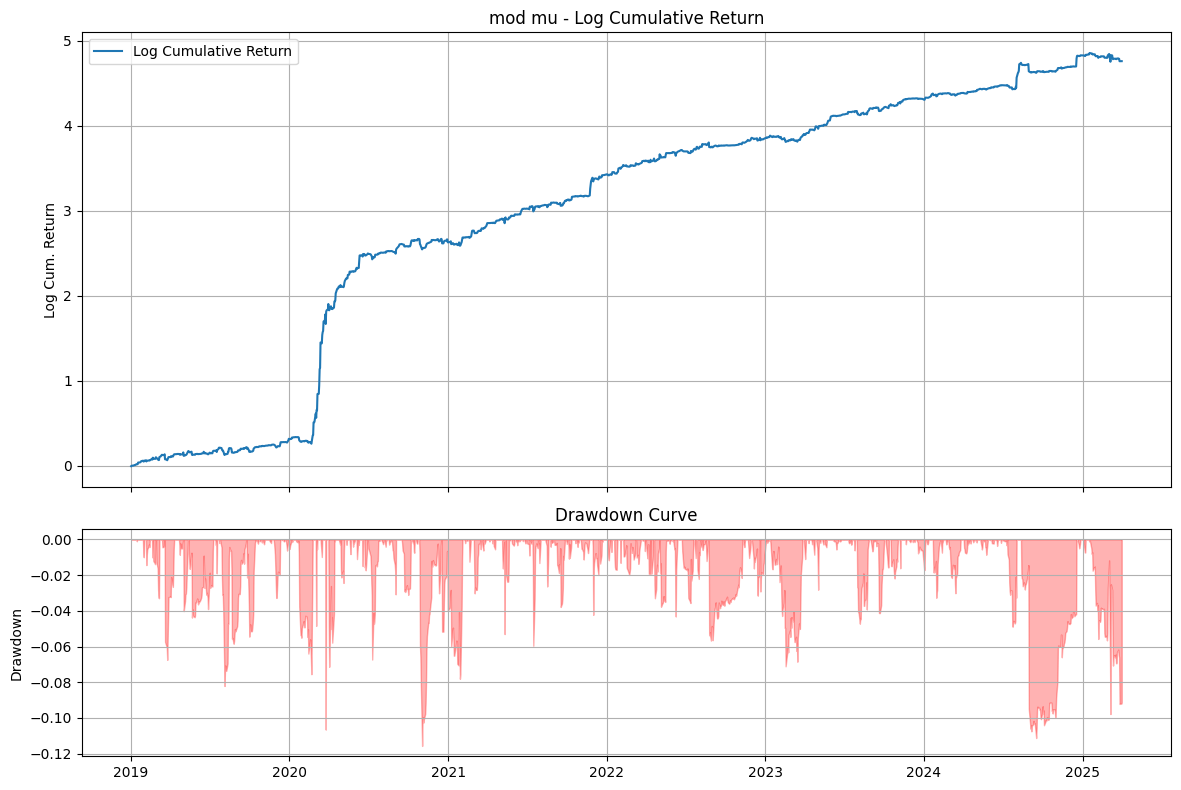

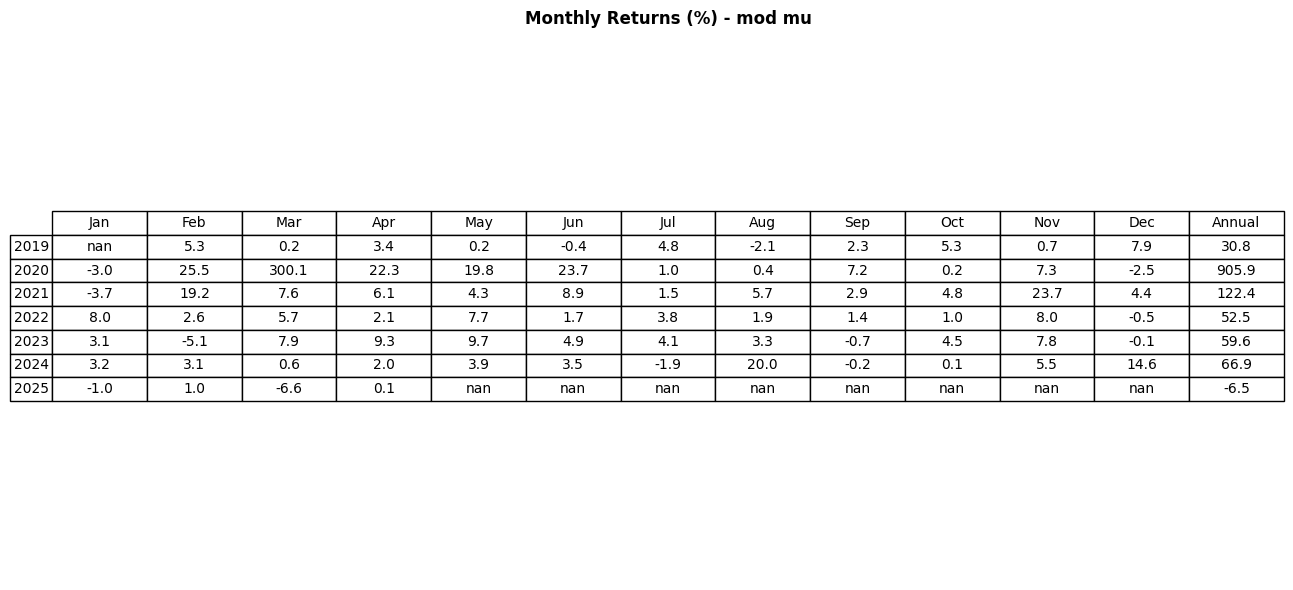

                      mod mu
Annual Return         1.1454
Annual Volatility     0.3086
Sharpe Ratio          2.6202
Sharpe Ratio2         3.7119
Max Drawdown         -0.1157
Calmar Ratio          9.9021
# of Trades        1571.0000


In [40]:
strats = Algo.to_pandas().set_index("Date")["algo_ret"].dropna()
strats = (
    Algo.to_pandas()
    .set_index("Date")["algo_ret"]
    .dropna()
    .loc["2019-01-01":]
)

report = PnLreport(strats, name="mod mu")
print(report)
